In [4]:
import numpy as np
import pandas as pd
from image_proc import image_proc
from image_gen import imagegen


In [10]:
process = image_proc('images','processed_imgs')
process.proc_save(remove_background=True,crop=True,save=True)

In [5]:
generator = imagegen('processed_imgs',6,(900,400),'background.png')

[4] images were selected
[1 5 0 3] were the indices that were selected
4


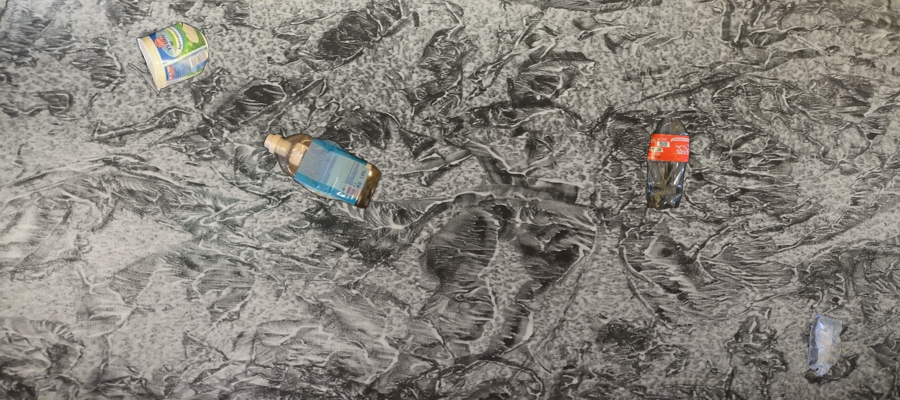

In [7]:
generator.test_resize()

In [9]:
s = '0004 a01b05c2d0e1f0g1h1.jpg'
s[7]

'1'